# Introduction

QA plots for the TPC detector

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

In [3]:
import os.path

# readme file of the macros, available if run under JenkinsCI
# https://github.com/sPHENIX-Collaboration/utilities/blob/master/jenkins/built-test/test-tracking-qa.sh 

macro_markdown = 'Fun4All-macros-README.md'

if os.path.isfile(macro_markdown) :
    with open(macro_markdown, 'r') as file:
        display(Markdown(file.read()))

<<<<<<< HEAD
[//]: # (This section starts with a 2nd level heading and get embedded in the result QA report at https://github.com/sPHENIX-Collaboration/QA-gallery/tree/QA-tracking-high-occupancy)

## Tracking QA at high occupancy

High occupancy tracking QA consists full tracker + reconstruction of events with 76 $\pi^+$, and 76 $\pi^-$ in a $\Delta\eta \times \Delta\phi = 0.5 \times 0.5$ window. In this small window, we would like to emulate the occupancy for 0-10% AuAu 200 GeV $\delta N_{Ch}/\delta\eta = 609$ [DOI: 10.1103/PhysRevC.83.024913]. Beyond this window, six more high $p_T>60$ GeV$/c$ pions are added to help constraint 3D vertex. 

Please note the calorimeters are disabled to improve execution speed, which also removed some of the correlated albedo background for the tracker. 

The source code of the macro can be found at https://github.com/sPHENIX-Collaboration/macros/tree/QA-tracking-high-occupancy or [comparing it to the master branch](https://github.com/sPHENIX-Collaboration/macros/compare/QA-tracking-high-occupancy?expand=1).
=======
[//]: # (This section starts with a 2nd level heading and get embedded in the result QA report at https://github.com/sPHENIX-Collaboration/QA-gallery/tree/QA-tracking-low-occupancy)

## Tracking QA at low occupancy

Low occupancy tracking QA concists full tracker + reconstruction of events with 20 $\pi^+$,  20 $\pi^-$ and one $\Upsilon(1S) \rightarrow e^+ e^-$. Please note the calorimeters are disabled to improve execution speed, which also removed some of the correlated albedo background for the tracker. 

The source code of the macro can be found at https://github.com/sPHENIX-Collaboration/macros/tree/QA-tracking-low-occupancy or [comparing it to the master branch](https://github.com/sPHENIX-Collaboration/macros/compare/QA-tracking-low-occupancy?expand=1).
>>>>>>> 15cad80c69c611809e5db1a4c1e6105061aa91a8


## `pyROOT` env check

In [4]:
import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

Welcome to JupyROOT 6.22/02


via sPHENIX software distribution at `/var/lib/jenkins/workspace/sPHENIX/Build-Master-gcc8/build/new/install.1`

## Plotting source code

In [5]:
import subprocess

try:
    git_url = \
        subprocess.run(['git','remote','get-url','origin'], stdout=subprocess.PIPE)\
        .stdout.decode('utf-8').strip()\
        .replace('git@github.com:','https://github.com/')

    display(Markdown(f"View the source code repository at {git_url}"))
except: # catch *all* exceptions
    #     well do nothing
    pass

View the source code repository at https://github.com/sPHENIX-Collaboration/QA-gallery.git

## JenkinsCI information (if available)

In [6]:
display(Markdown('Some further details about the QA run, if executed under the Jenkins CI:'))

checkrun_repo_commit = os.getenv("checkrun_repo_commit")
if checkrun_repo_commit is not None:
    display(Markdown(f"* The commit being checked is {checkrun_repo_commit}"))
        
ghprbPullLink = os.getenv("ghprbPullLink")
if ghprbPullLink is not None:
    display(Markdown(f"* Link to the pull request: {ghprbPullLink}"))

BUILD_URL =  os.getenv("BUILD_URL")
if BUILD_URL is not None:
    display(Markdown(f"* Link to the build: {BUILD_URL}"))

git_url_macros =  os.getenv("git_url_macros")
sha_macros =  os.getenv("sha_macros")
if git_url_macros is not None:
    display(Markdown(f"* Git repo for macros: {git_url_macros} , which merges `{sha_macros}` and the QA tracking branch"))

RUN_ARTIFACTS_DISPLAY_URL = os.getenv("RUN_ARTIFACTS_DISPLAY_URL")
if RUN_ARTIFACTS_DISPLAY_URL is not None:
    display(Markdown(f"* Download the QA ROOT files: {RUN_ARTIFACTS_DISPLAY_URL}"))

JENKINS_URL  = os.getenv("JENKINS_URL")
if JENKINS_URL is not None:
    display(Markdown(f"Automatically generated by [sPHENIX Jenkins continuous integration]({JENKINS_URL}) [![sPHENIX](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/sphenix-logo-white-bg-72p.png)](https://www.sphenix.bnl.gov/web/) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [![jenkins.io](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/jenkins_logo_title-72p.png)](https://jenkins.io/)"))

Some further details about the QA run, if executed under the Jenkins CI:

* The commit being checked is sPHENIX-Collaboration/coresoftware/72736b5fb1f9436e4a03b04e9dd7ff732d102828

* Link to the pull request: https://github.com/sPHENIX-Collaboration/coresoftware/pull/1243

* Link to the build: https://web.sdcc.bnl.gov/jenkins-sphenix/job/sPHENIX/job/test-tracking-high-occupancy-qa/1116/

* Git repo for macros: https://github.com/sPHENIX-Collaboration/macros.git , which merges `*/master` and the QA tracking branch

* Download the QA ROOT files: https://web.sdcc.bnl.gov/jenkins-sphenix/job/sPHENIX/job/test-tracking-high-occupancy-qa/1116/display/redirect?page=artifacts

Automatically generated by [sPHENIX Jenkins continuous integration](https://web.sdcc.bnl.gov/jenkins-sphenix/) [![sPHENIX](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/sphenix-logo-white-bg-72p.png)](https://www.sphenix.bnl.gov/web/) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [![jenkins.io](https://raw.githubusercontent.com/sPHENIX-Collaboration/utilities/master/jenkins/material/jenkins_logo_title-72p.png)](https://jenkins.io/)


# Initialization

In [7]:
%%cpp -d

#include "QA_Draw_Utility.C"

#include <sPhenixStyle.C>

#include <TFile.h>
#include <TLine.h>
#include <TString.h>
#include <TTree.h>
#include <cassert>
#include <cmath>

In [8]:
%%cpp

SetsPhenixStyle();
TVirtualFitter::SetDefaultFitter("Minuit2");

// test sPHENIX lib load
// gSystem->Load("libg4eval.so");

// test libs
// gSystem->ListLibraries();

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


## Inputs and file checks

In [9]:

qa_file_name_new = os.getenv("qa_file_name_new")
if qa_file_name_new is None:
    qa_file_name_new = "G4sPHENIX_test-tracking-low-occupancy-qa_Event100_Sum10_qa.root"
    display(Markdown(f"`qa_file_name_new` env not set. use the default `qa_file_name_new={qa_file_name_new}`"))

qa_file_name_ref = os.getenv("qa_file_name_ref")
if qa_file_name_ref is None:
    qa_file_name_ref = "reference/G4sPHENIX_test-tracking-low-occupancy-qa_Event100_Sum10_qa.root"
    display(Markdown(f"`qa_file_name_ref` env not set. use the default `qa_file_name_ref={qa_file_name_ref}`"))
elif qa_file_name_ref == 'None':
    qa_file_name_ref = None
    display(Markdown(f"`qa_file_name_ref` = None and we are set to not to use the reference histograms"))
    


In [10]:
# qa_file_new = ROOT.TFile.Open(qa_file_name_new);

# assert qa_file_new.IsOpen()
# qa_file_new.ls()
display(Markdown(f"Openning QA file at `{qa_file_name_new}`"))
ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_new = new TFile(\"{qa_file_name_new}\");")
ROOT.gInterpreter.ProcessLine(f"const char * qa_file_name_new = \"{qa_file_name_new}\";")

if qa_file_name_ref is not None:
#     qa_file_ref = ROOT.TFile.Open(qa_file_name_ref);

#     assert qa_file_ref.IsOpen()
    display(Markdown(f"Openning QA reference file at `{qa_file_name_ref}`"))
    ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_ref = new TFile(\"{qa_file_name_ref}\");")
    ROOT.gInterpreter.ProcessLine(f"const char *  qa_file_name_ref = \"{qa_file_name_ref}\";")
else:
    ROOT.gInterpreter.ProcessLine(f"TFile *qa_file_ref = nullptr;")
    ROOT.gInterpreter.ProcessLine(f"const char *  qa_file_name_ref = nullptr;")


Openning QA file at `G4sPHENIX_test-tracking_Event50_Sum10_qa.root`

Openning QA reference file at `reference/G4sPHENIX_test-tracking_Event50_Sum10_qa.root`

In [11]:
%%cpp

if (qa_file_new == nullptr) 
{
    cout <<"Error, can not open QA root file"<<qa_file_name_new<<endl;
    exit(1);
}

// list inputs histograms if needed
// qa_file_new ->ls();

//TFile *qa_file_ref = NULL;
//if (qa_file_name_ref)
//{
//    qa_file_ref = new TFile(qa_file_name_ref);
//  
//    if (qa_file_ref == nullptr) 
//    {
//        cout <<"Error, can not open QA root file"<<qa_file_name_ref<<endl;
//        exit(1);
//    }
//}

## Utilities (invisible to HTML output)

In [12]:
%%cpp
//constants

const char *hist_name_prefix = "QAG4SimulationTpc";
static constexpr int nregions_tpc = 3;

In [13]:
%%cpp -d
// utility functions for batch plotting


TCanvas* Draw( TFile* qa_file_new, TFile* qa_file_ref, const TString& hist_name_prefix, const TString& tag )
{

const TString prefix = TString("h_") + hist_name_prefix + TString("_");

auto cv = new TCanvas(
          TString("QA_Draw_Tpc_") + tag + TString("_") + hist_name_prefix,
          TString("QA_Draw_Tpc_") + tag + TString("_") + hist_name_prefix,
  1800, 1000);

cv->Divide( nregions_tpc, 1 );
for( int region = 0; region < nregions_tpc; ++region )
{

  // get histograms
  auto hnew = static_cast<TH1*>( qa_file_new->GetObjectChecked( Form( "%s%s_%i", prefix.Data(), tag.Data(), region ), "TH1" ) );
  hnew->Scale( 1./hnew->GetEntries() );
  hnew->SetMinimum(0);

  // reference
  auto href = qa_file_ref ? static_cast<TH1*>( qa_file_ref->GetObjectChecked( Form( "%s%s_%i", prefix.Data(), tag.Data(), region ), "TH1" ) ) : nullptr;
  if( href )
  {
    href->Scale( 1./href->GetEntries() );
    href->SetMinimum(0);
  }

  // draw
  cv->cd( region+1 );
  DrawReference(hnew, href);

  auto line = VerticalLine( gPad, 0 );
  line->Draw();
}

return cv;

}

TCanvas* Draw_eff( TFile* qa_file_new, TFile* qa_file_ref, const TString& hist_name_prefix, const TString& tag )
{

    const TString prefix = TString("h_") + hist_name_prefix + TString("_");

    auto cv = new TCanvas(
              TString("QA_Draw_Tpc_") + tag + TString("_") + hist_name_prefix,
              TString("QA_Draw_Tpc_") + tag + TString("_") + hist_name_prefix,
              1800, 1000);

    // get histograms
    auto hnew0 = static_cast<TH1*>( qa_file_new->GetObjectChecked( Form( "%s%s_0", prefix.Data(), tag.Data()), "TH1" ) );
    auto hnew1 = static_cast<TH1*>( qa_file_new->GetObjectChecked( Form( "%s%s_1", prefix.Data(), tag.Data()), "TH1" ) );

    hnew1->Divide(hnew1, hnew0, 1, 1, "B");
    hnew1->SetMinimum(0);

    // reference
    auto href0 = qa_file_ref ? static_cast<TH1*>( qa_file_ref->GetObjectChecked( Form( "%s%s_0", prefix.Data(), tag.Data()), "TH1" ) ) : nullptr;
    auto href1 = qa_file_ref ? static_cast<TH1*>( qa_file_ref->GetObjectChecked( Form( "%s%s_1", prefix.Data(), tag.Data()), "TH1" ) ) : nullptr;
    if( href0 )
      {
    href1->Divide(href1, href0, 1, 1, "B");
    href1->SetMinimum(0);
      }

    // draw
    DrawReference(hnew1, href1);

    auto line = HorizontalLine( gPad, 1 );
    line->Draw();


    return cv;

}

# Cluster Efficiency

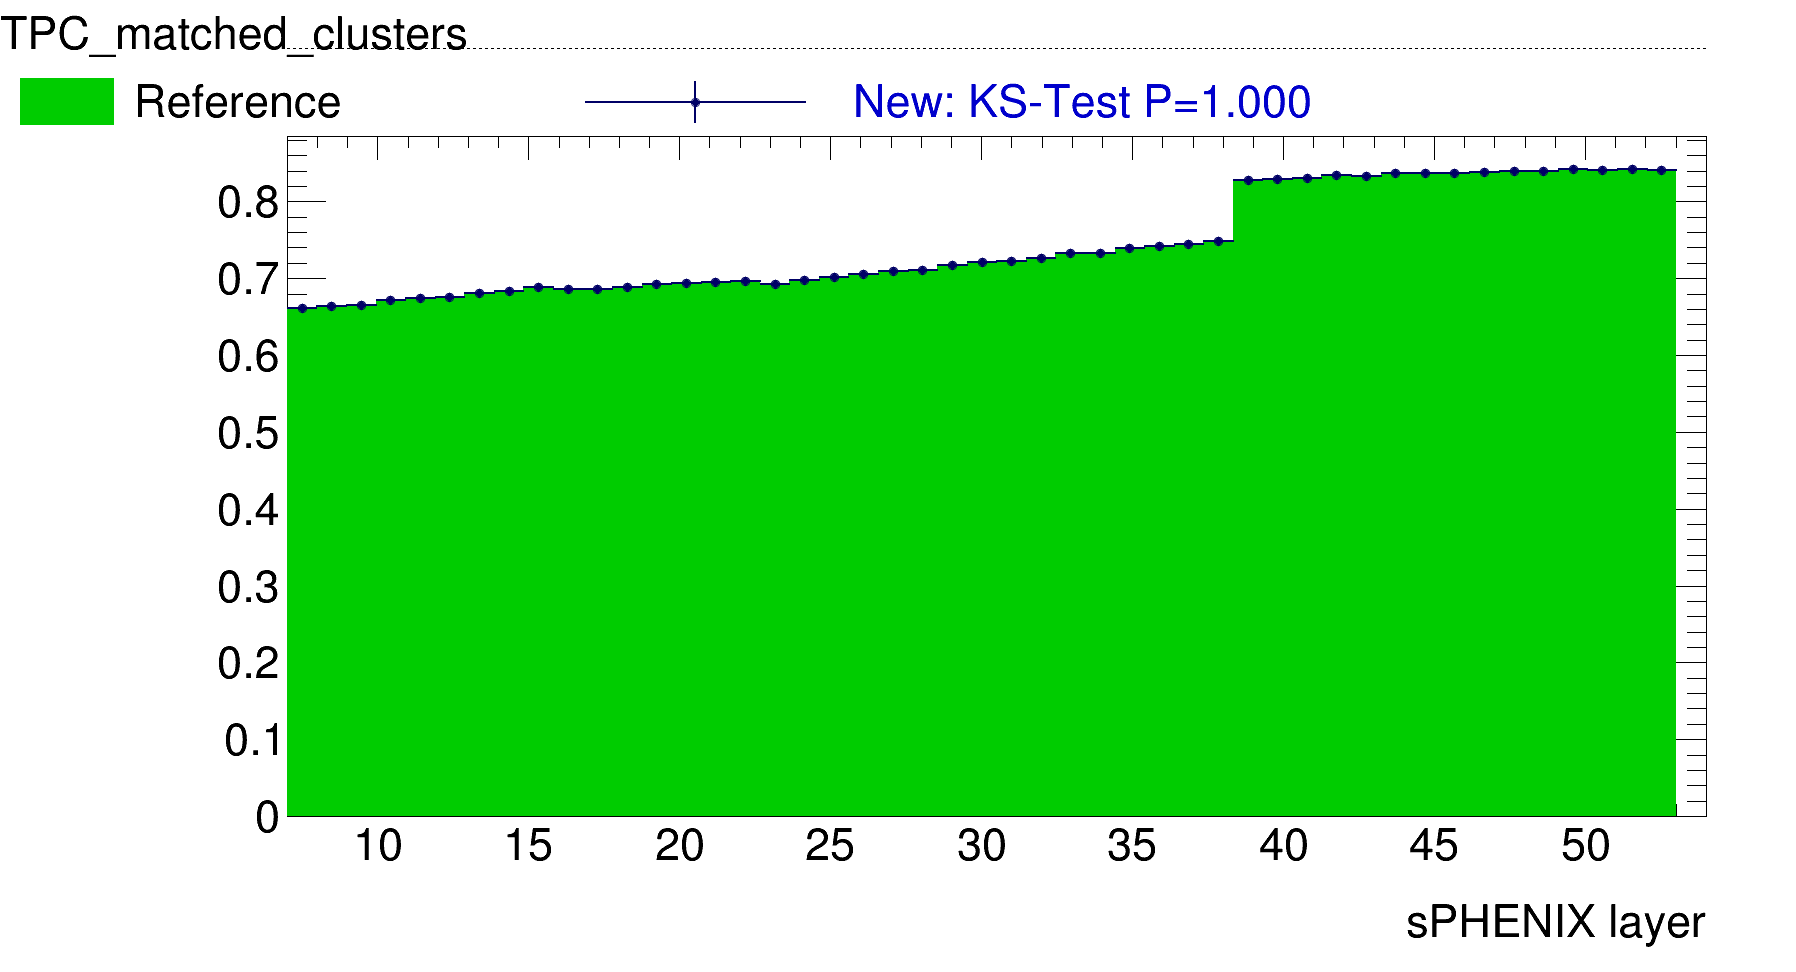

In [14]:
%%cpp

Draw_eff( qa_file_new, qa_file_ref, hist_name_prefix, "efficiency" ) -> Draw();

# Azimuthal arc-length, $r \Delta\phi$, residuals, errors and pulls

## Residuals

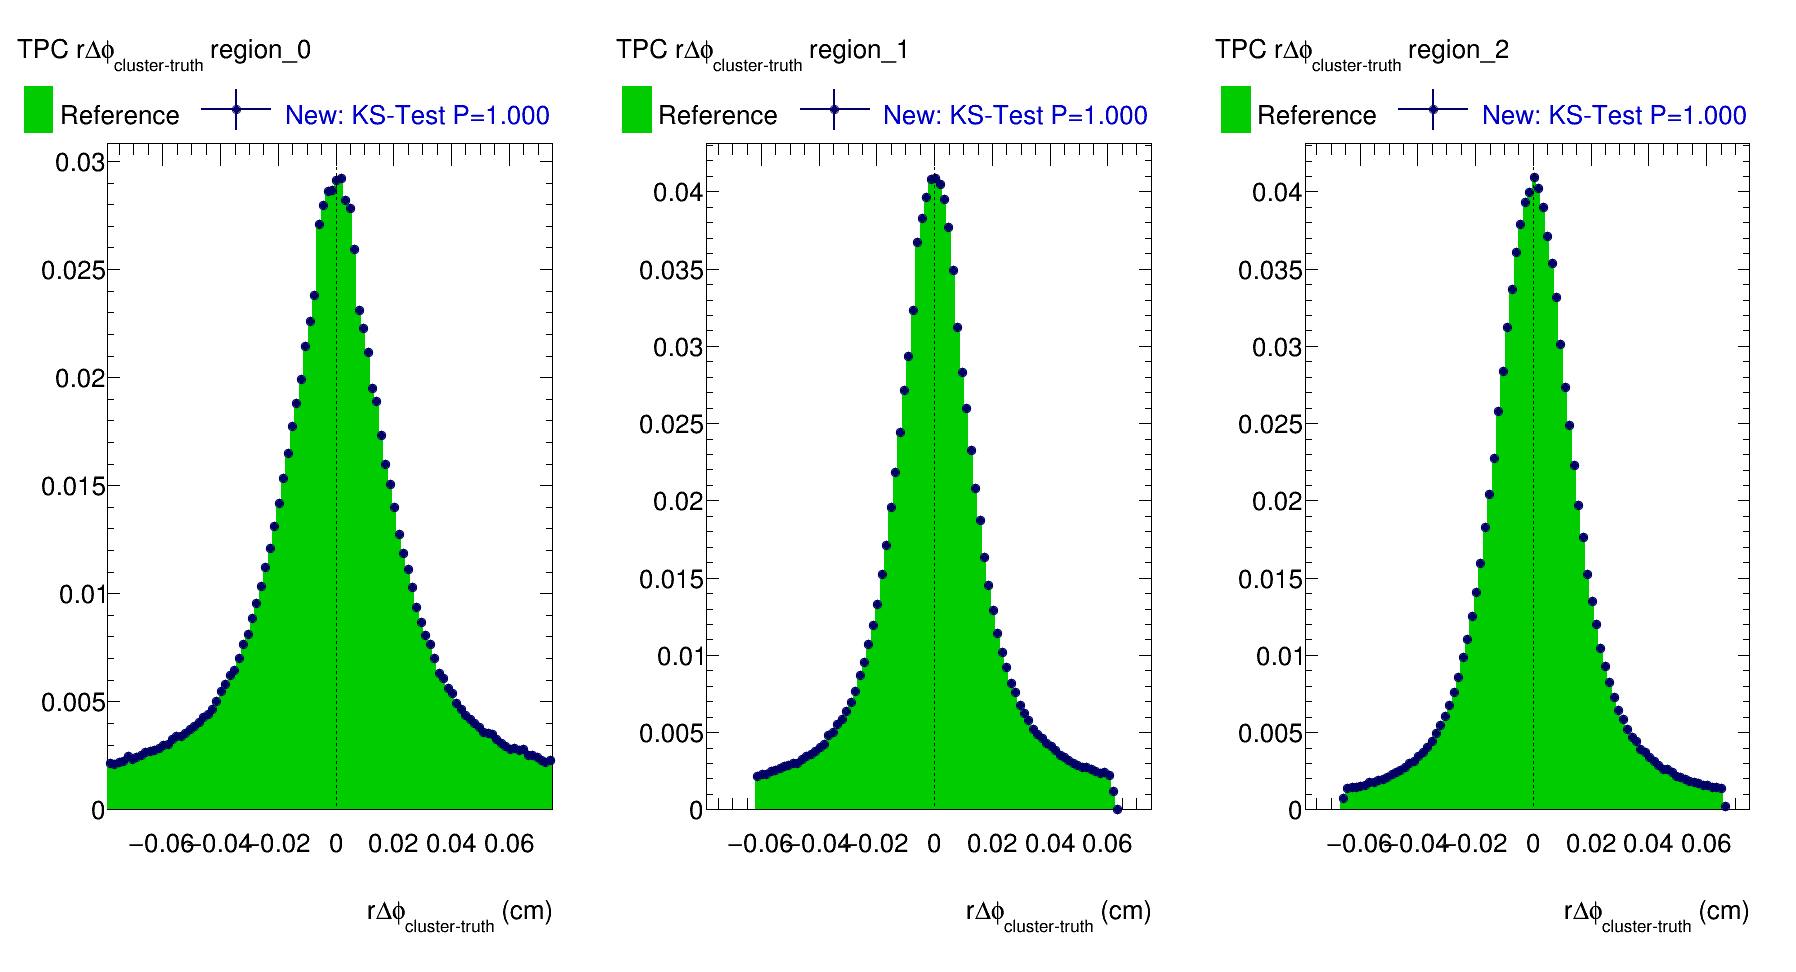

In [15]:
%%cpp

Draw( qa_file_new, qa_file_ref, hist_name_prefix, "drphi" )-> Draw();

## Errors 

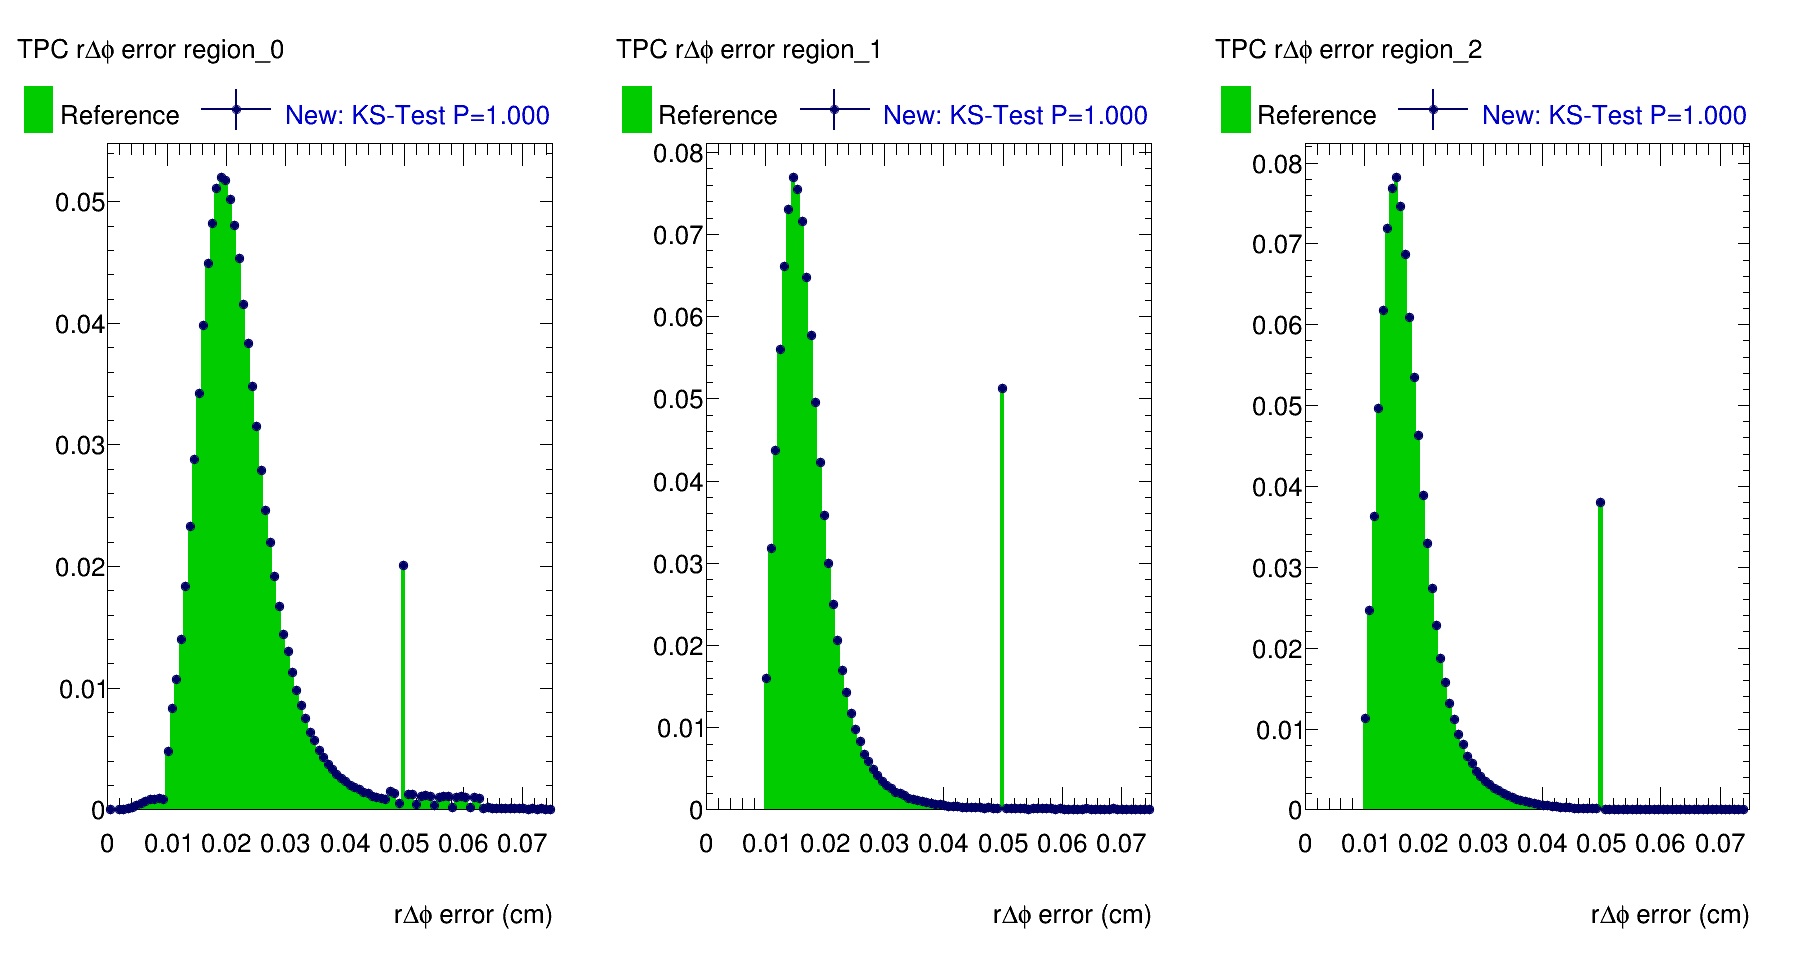

In [16]:
%%cpp

Draw( qa_file_new, qa_file_ref, hist_name_prefix, "rphi_error" )-> Draw();

## Pulls

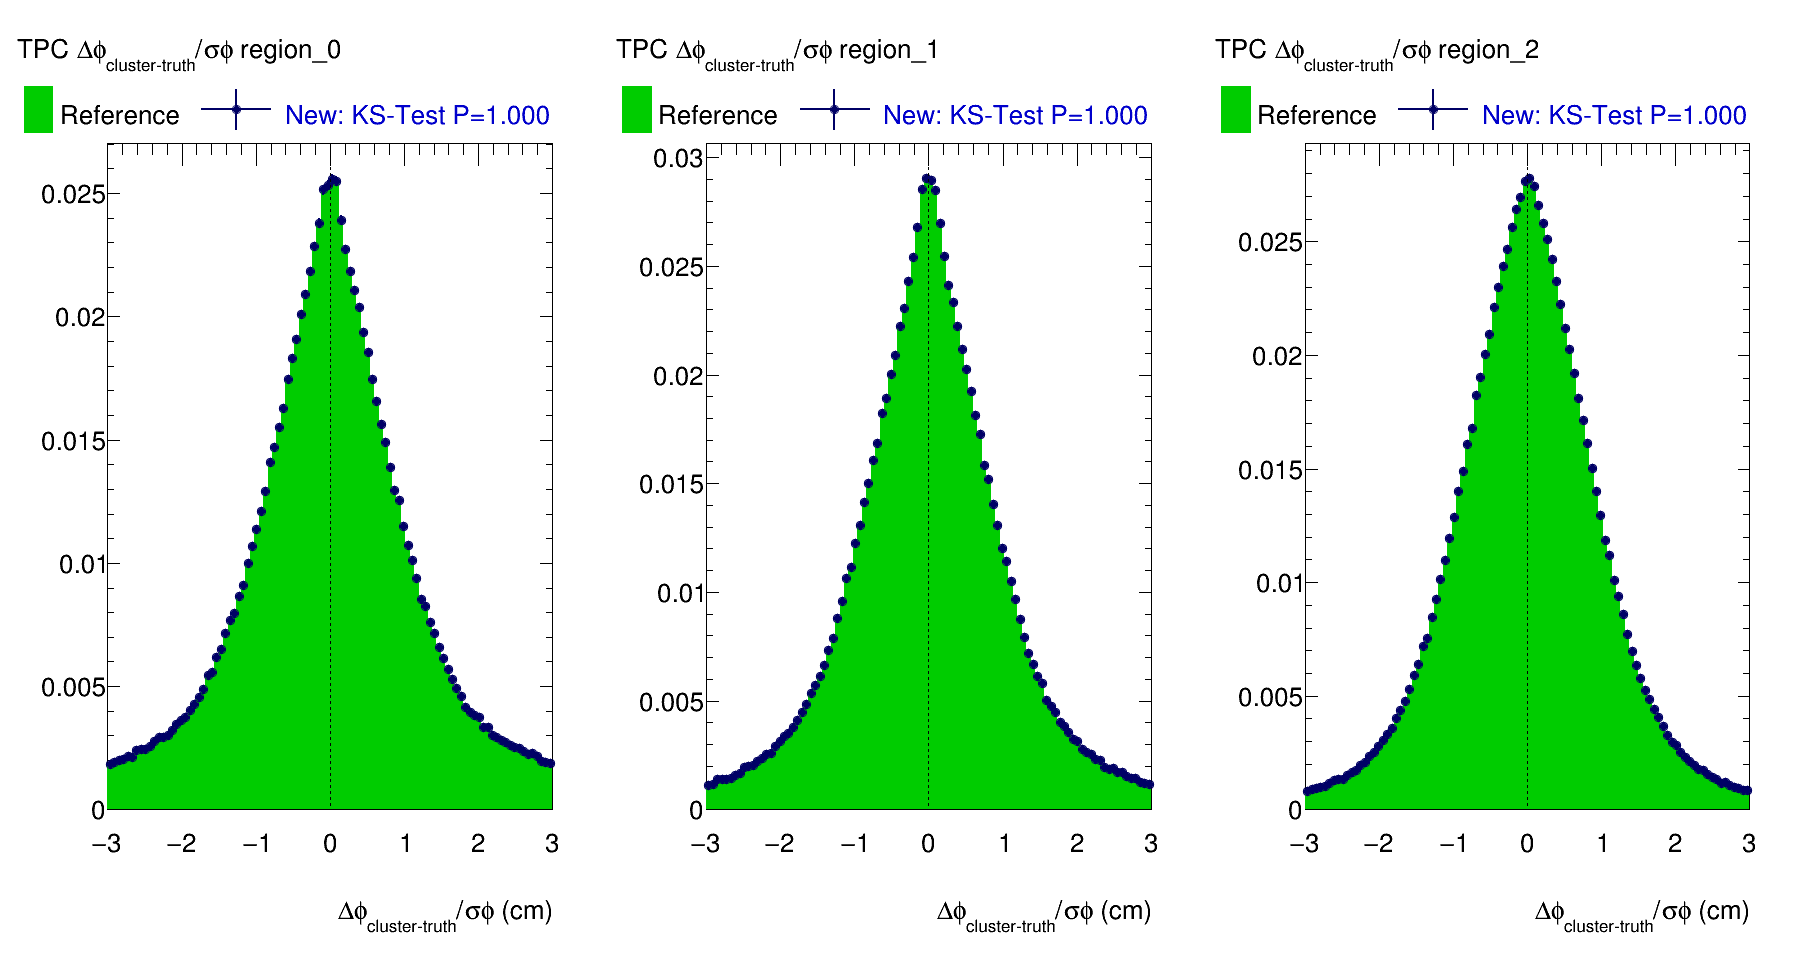

In [17]:
%%cpp

Draw( qa_file_new, qa_file_ref, hist_name_prefix, "phi_pulls" )-> Draw();

# $z$ residuals, errors and pulls

## Residuals

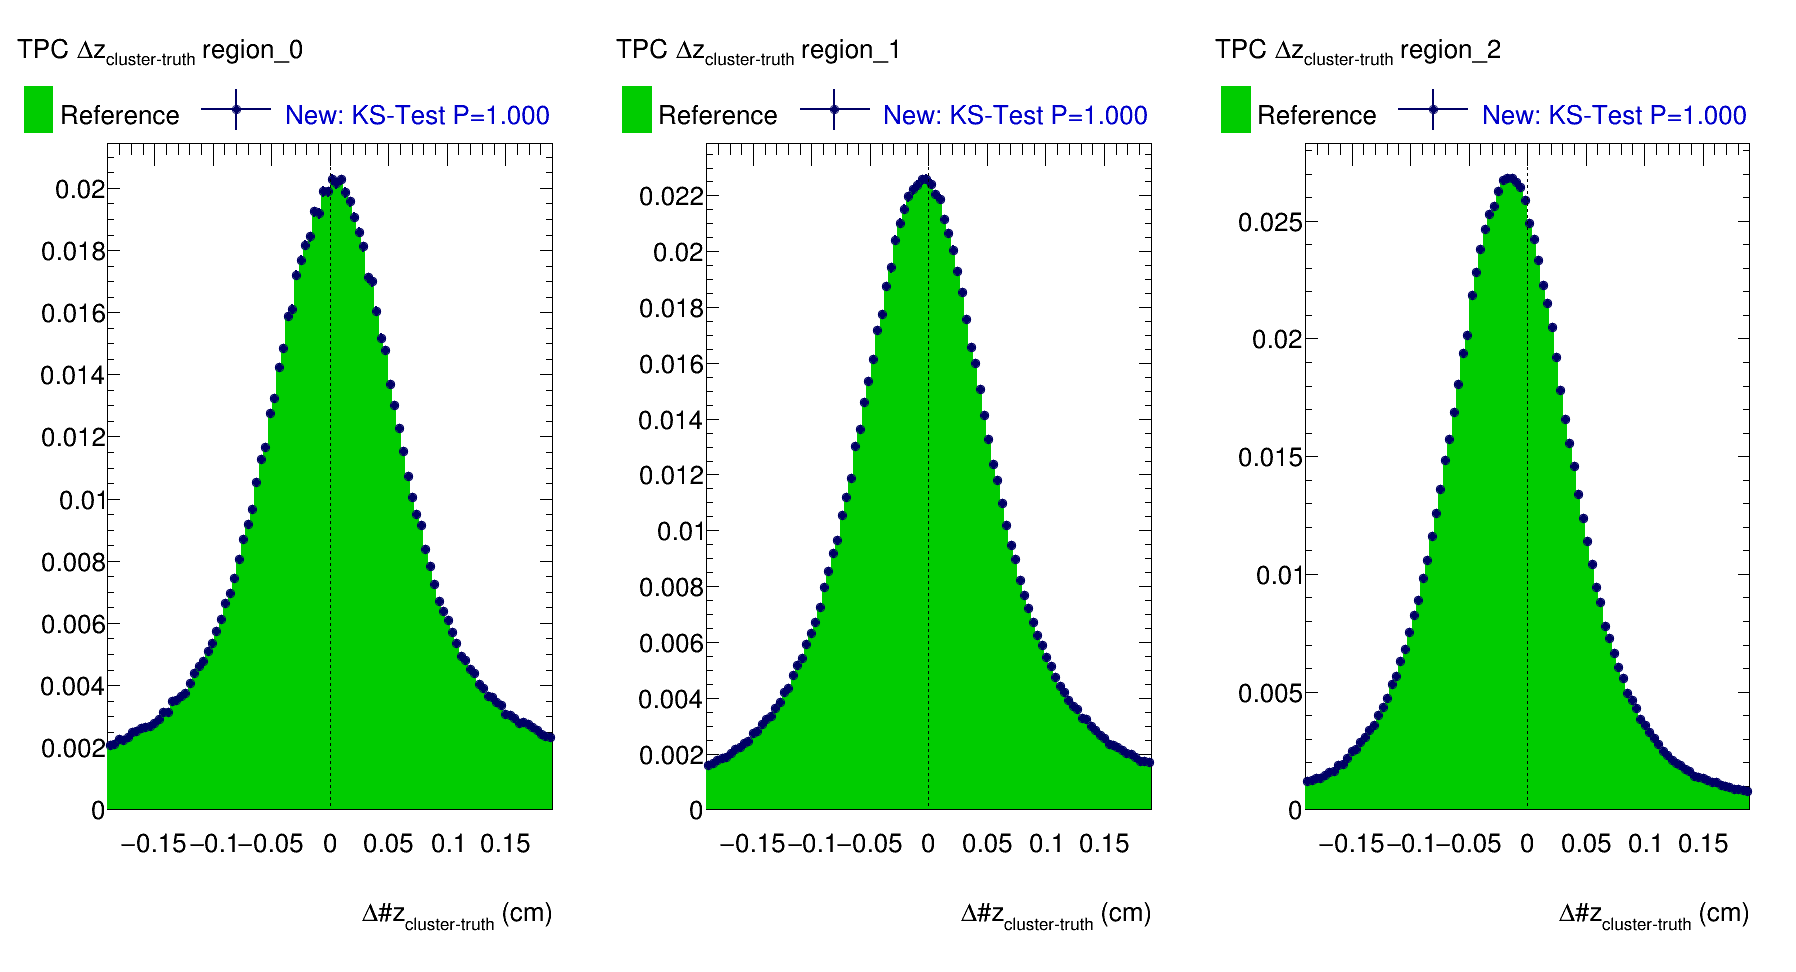

In [18]:
%%cpp

Draw( qa_file_new, qa_file_ref, hist_name_prefix, "dz" )-> Draw();

## Errors 

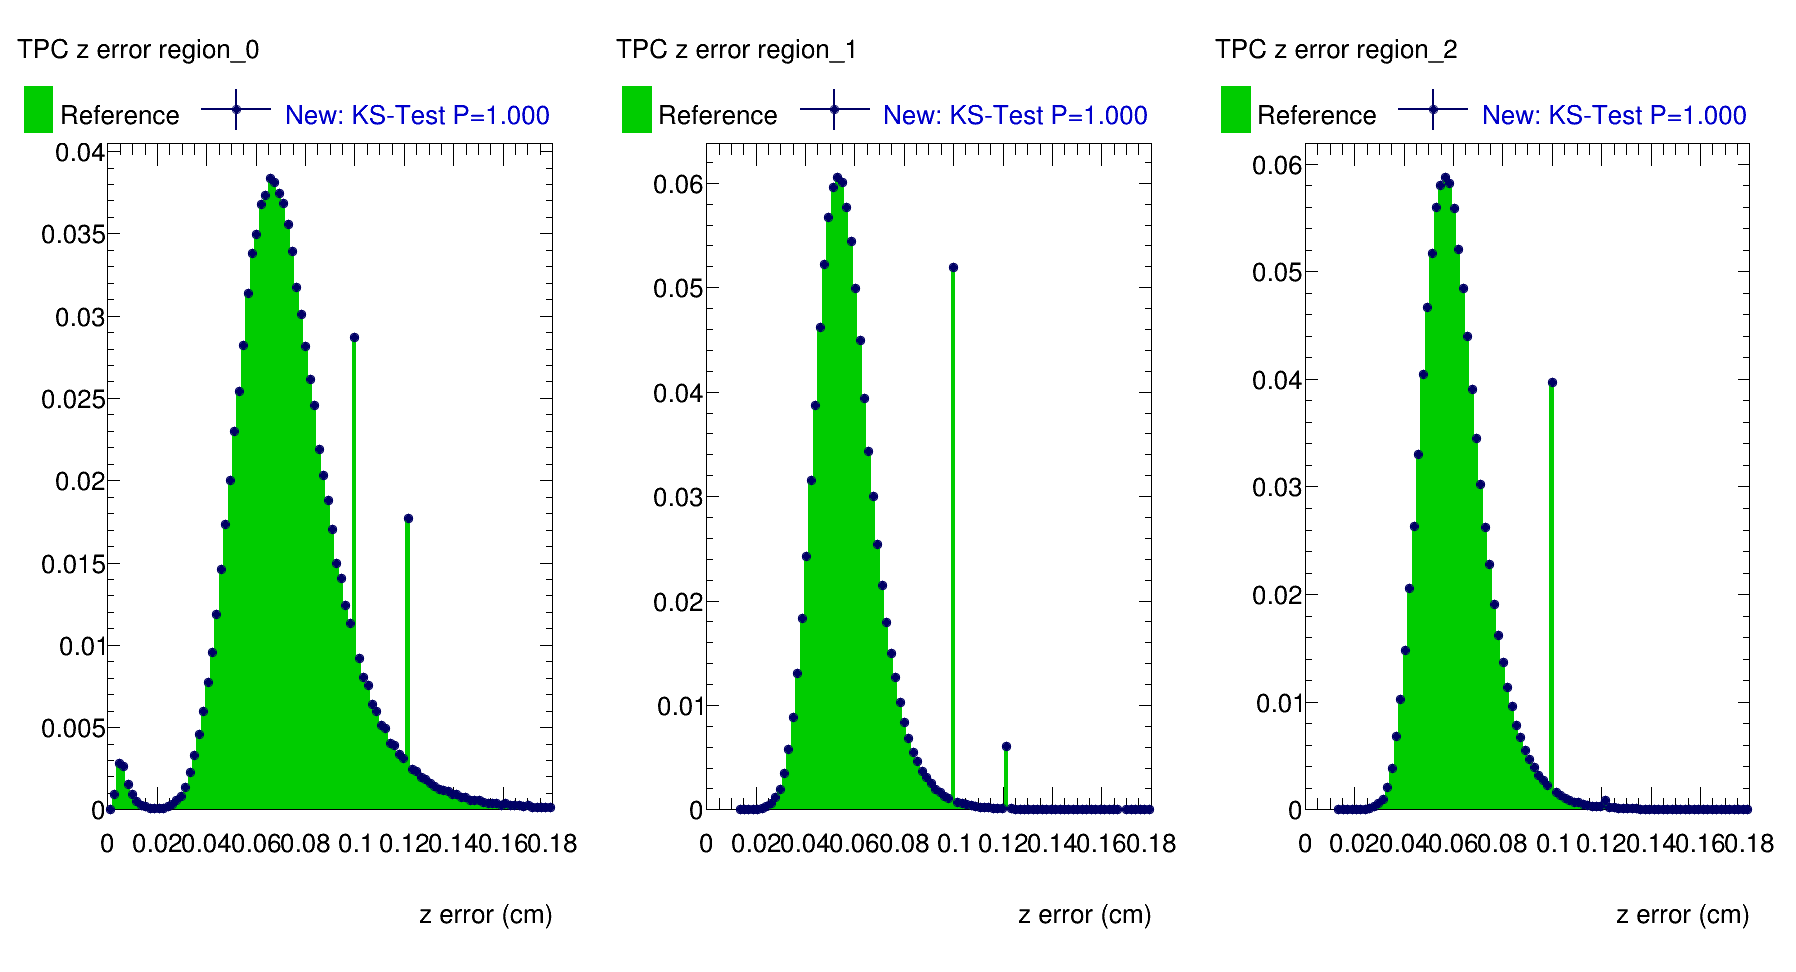

In [19]:
%%cpp

Draw( qa_file_new, qa_file_ref, hist_name_prefix, "z_error" )-> Draw();

## Pulls

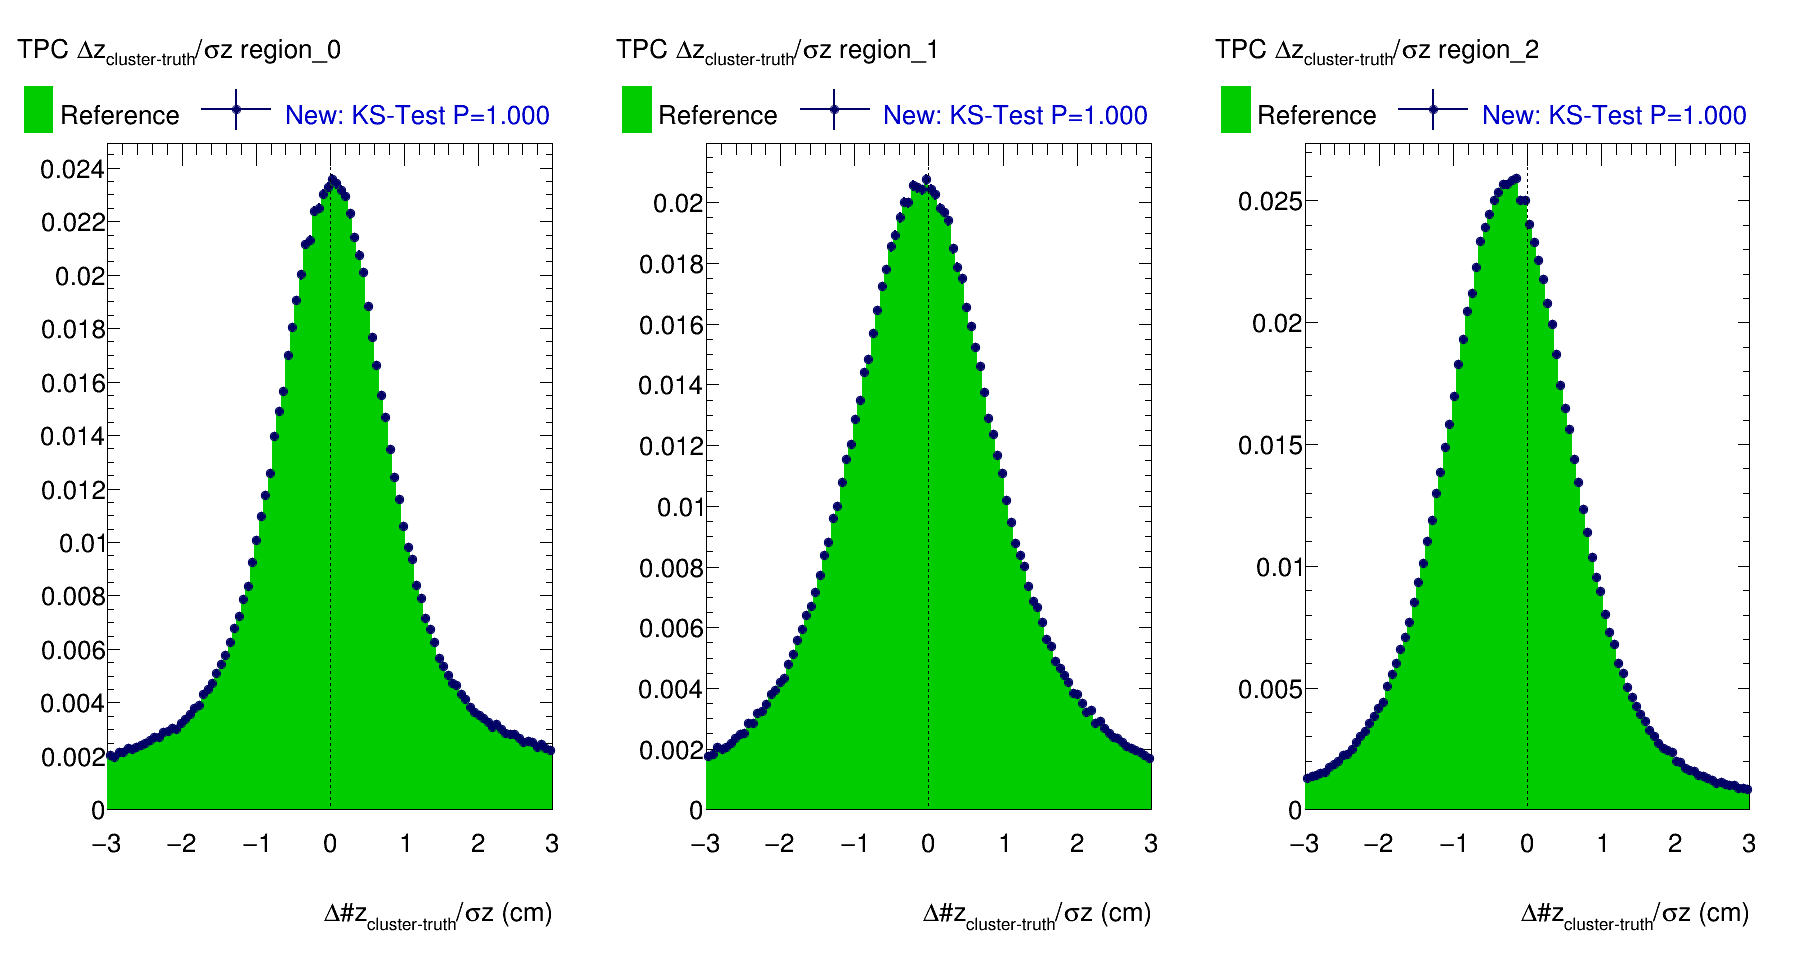

In [20]:
%%cpp

Draw( qa_file_new, qa_file_ref, hist_name_prefix, "z_pulls" )-> Draw();

# Cluster sizes

## Cluster size

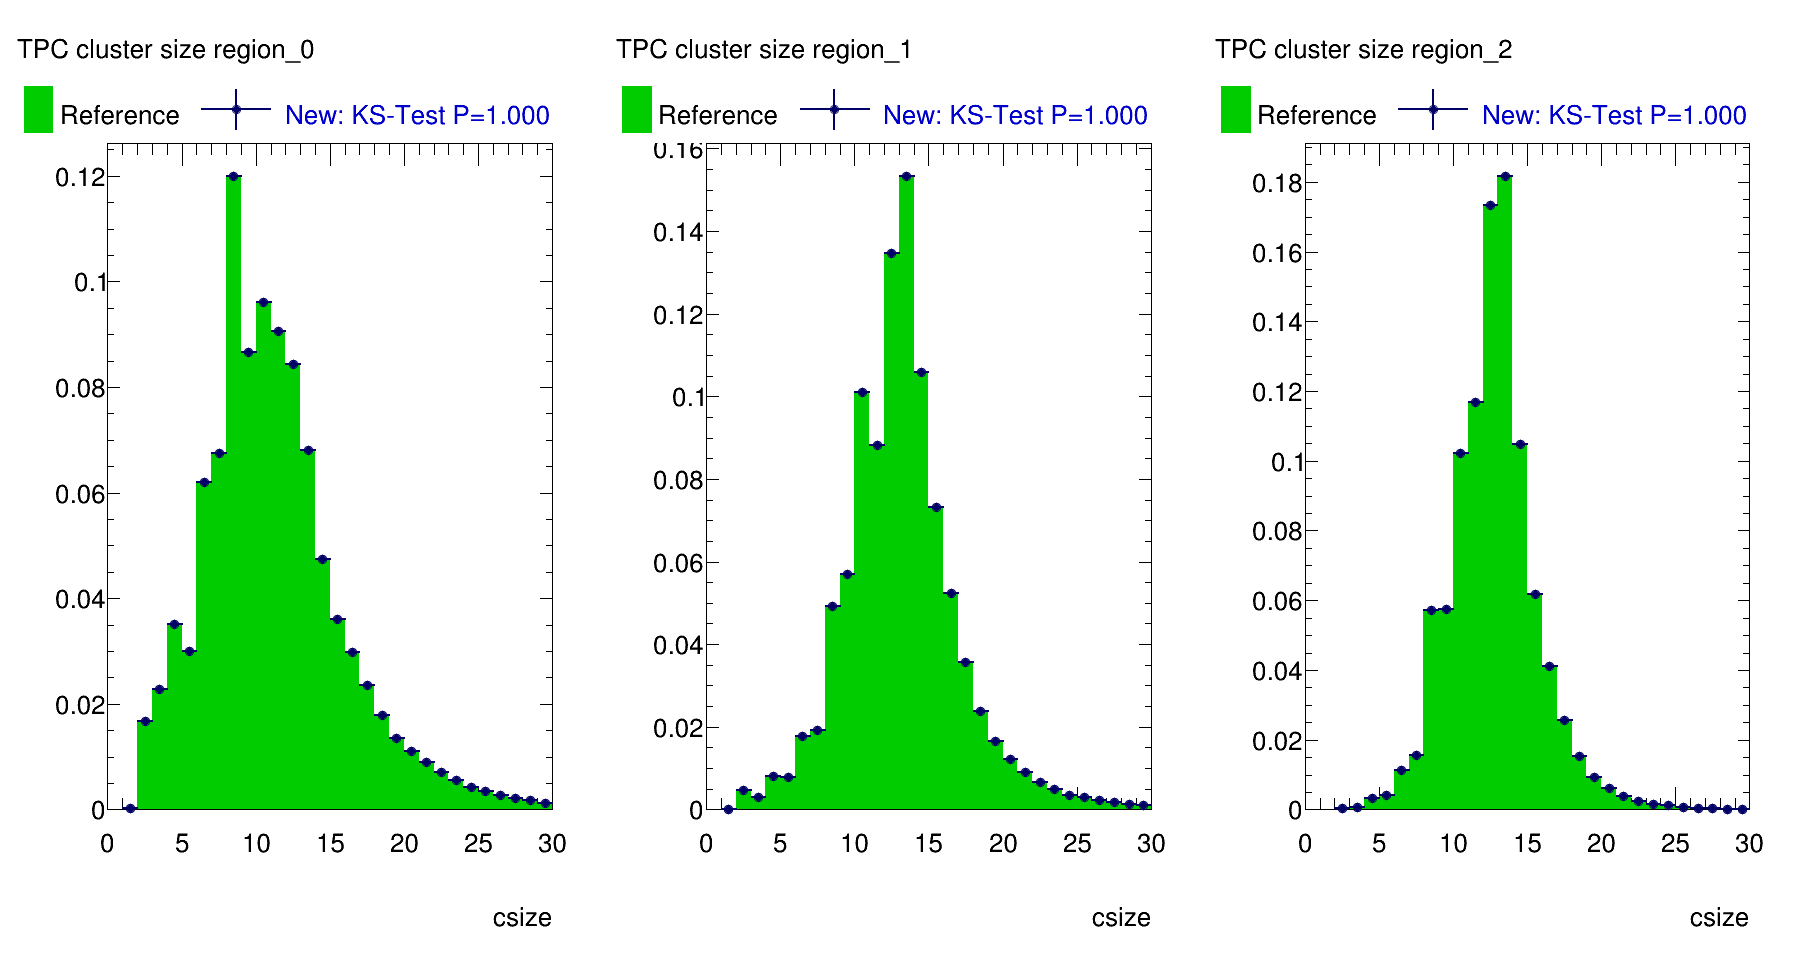

In [21]:
%%cpp

Draw( qa_file_new, qa_file_ref, hist_name_prefix, "clus_size" )-> Draw();

## Cluster azimuthal size 

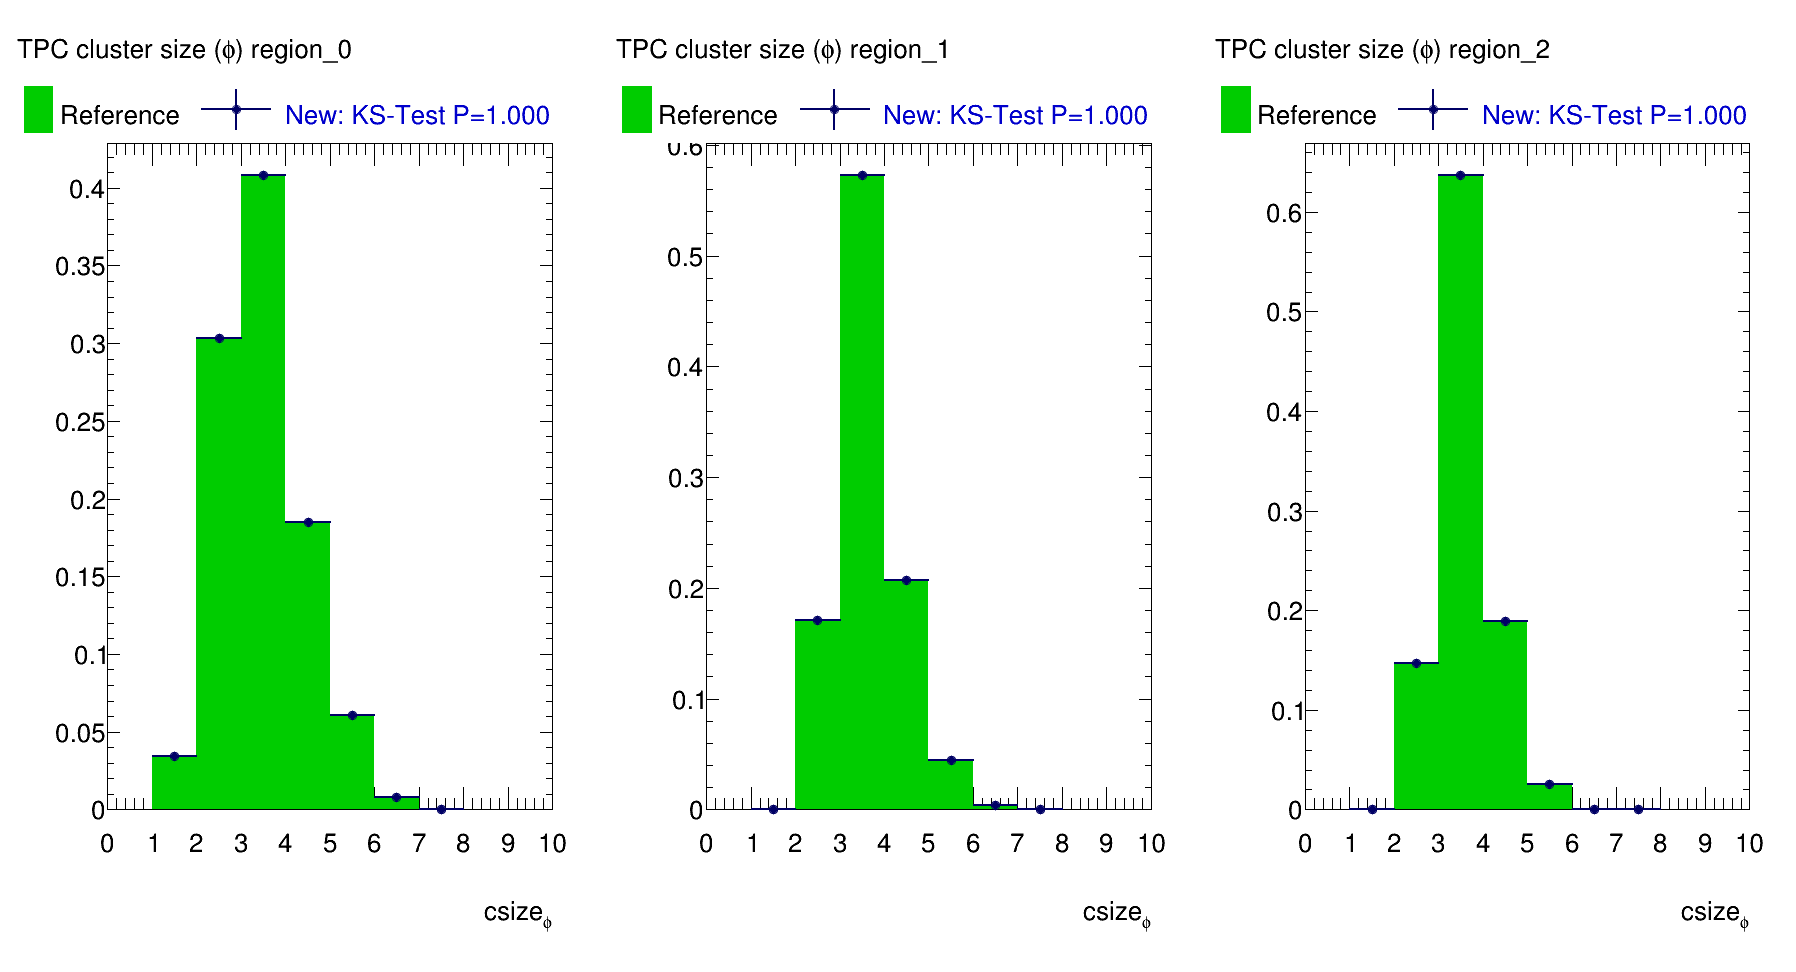

In [22]:
%%cpp

Draw( qa_file_new, qa_file_ref, hist_name_prefix, "clus_size_phi" )-> Draw();

## Cluster $z$-size

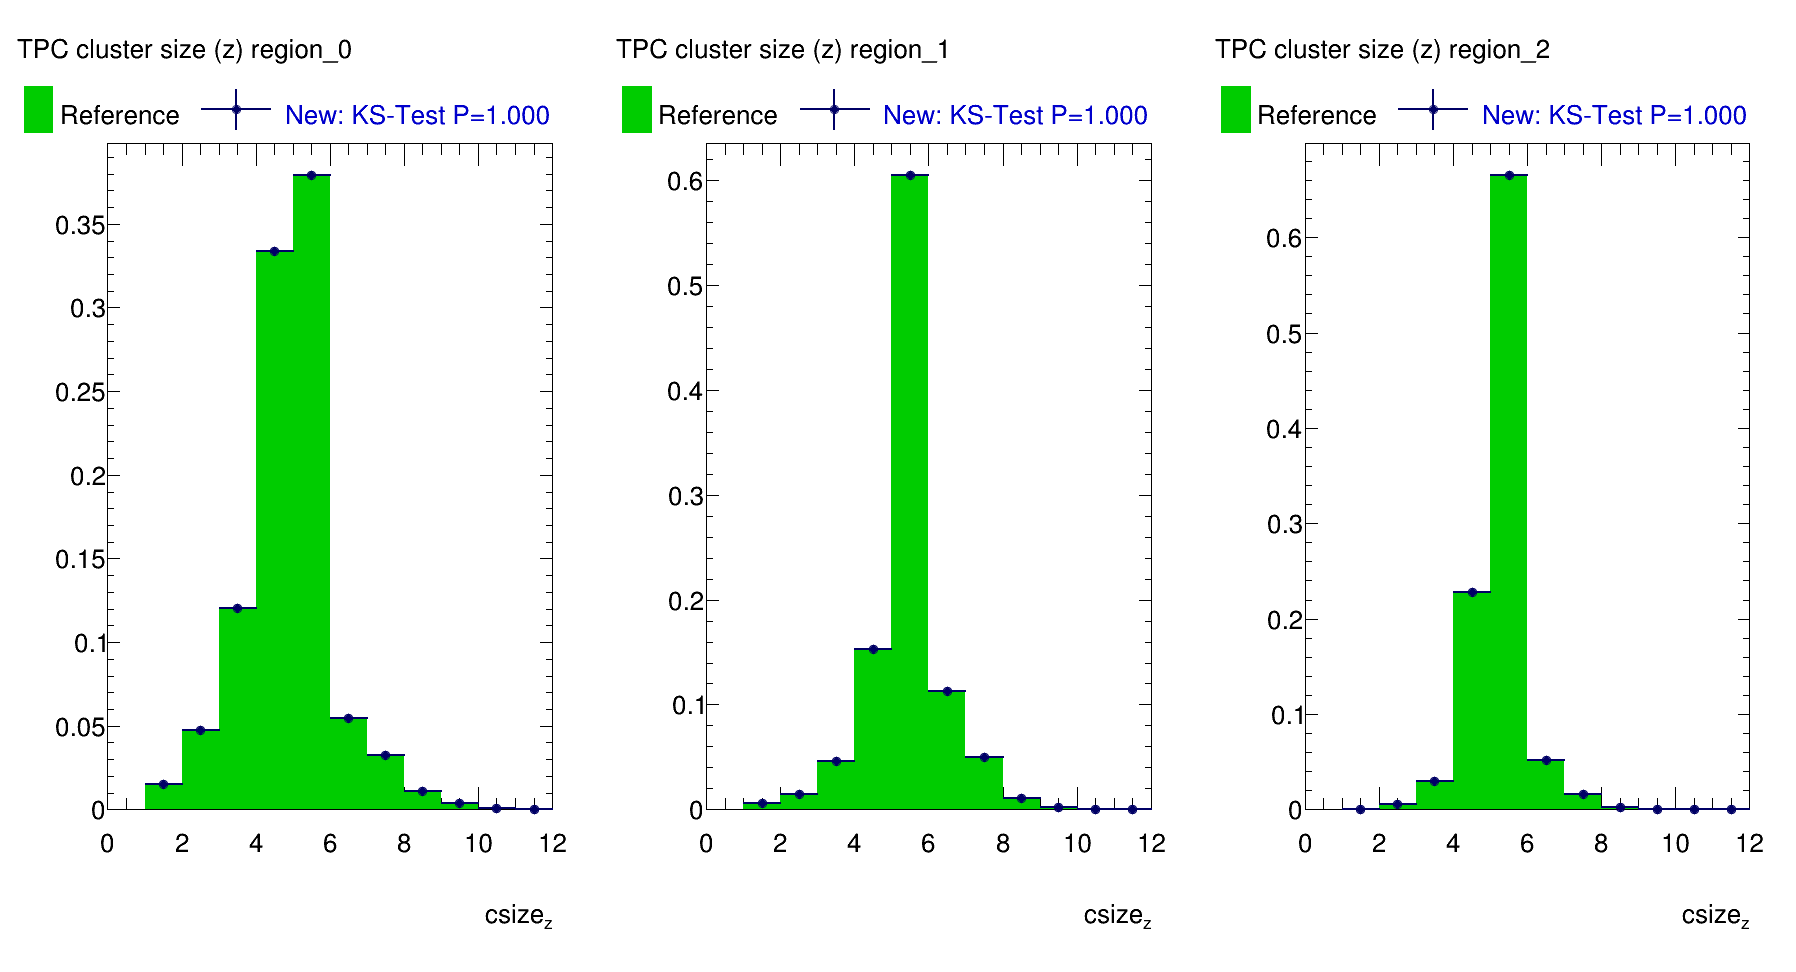

In [23]:
%%cpp

Draw( qa_file_new, qa_file_ref, hist_name_prefix, "clus_size_z" )-> Draw();

# Summary statistics

In [24]:
%%cpp

KSTestSummary::getInstance()->make_summary_txt("QA-Tpc.txt");

This notebook contains 28 KSTets: combined Chi2/nDoF = -0 / 56, and combined __p-Value = 1__


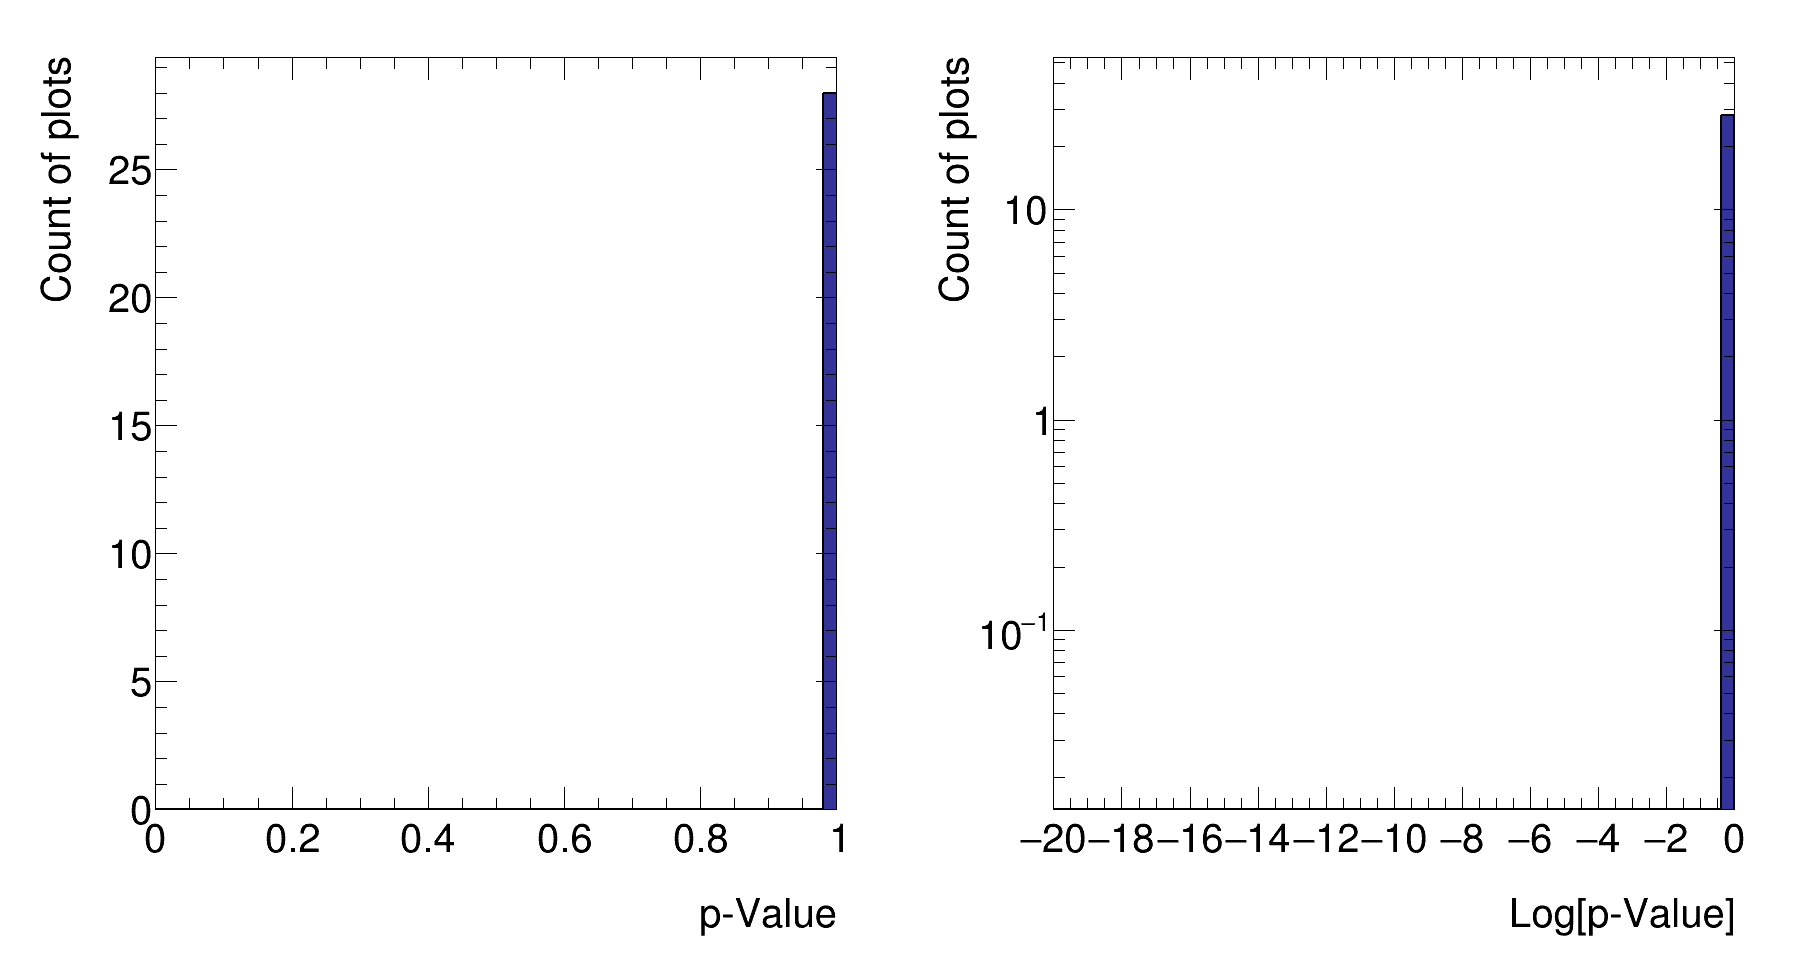

In [25]:
%%cpp

KSTestSummary::getInstance()->make_summary_TCanvas() -> Draw();